## 状态

In [1]:
from langgraph.graph import StateGraph

# 使用 stategraph 接收一个字典
builder = StateGraph(dict) 

In [2]:
builder

In [4]:
builder.schemas

{dict: {'__root__': <langgraph.channels.last_value.LastValue at 0x2a8b9d7a340>}}

## 定义两个节点

In [9]:
def to_uppercase(state):
    print(f"[to_uppercase] Initial state: {state}")
    return {"text": state["text"].upper()}

def to_lowercase(state):
    print(f"[to_lowercase] Received state: {state}")
    return {"text": state["text"].lower()}


In [10]:
def build_graph():
    builder = StateGraph(dict)  # 使用 Pydantic 模型作为状态对象
    
    # 添加节点
    builder.add_node("to_uppercase", to_uppercase)
    builder.add_node("to_lowercase", to_lowercase)
    
    # 添加边
    builder.add_edge(START, "to_uppercase")  # 从起始节点到转大写节点
    builder.add_edge("to_uppercase", "to_lowercase")  # 从转大写到转小写节点
    builder.add_edge("to_lowercase", END)  # 从转小写到结束节点
    
    # 编译图
    return builder.compile()

In [13]:
from langgraph.graph import START, END
graph = build_graph()

In [17]:
graph.nodes

{'__start__': <langgraph.pregel._read.PregelNode at 0x2a8bb08b890>,
 'to_uppercase': <langgraph.pregel._read.PregelNode at 0x2a8bb0884d0>,
 'to_lowercase': <langgraph.pregel._read.PregelNode at 0x2a8bb088f20>}

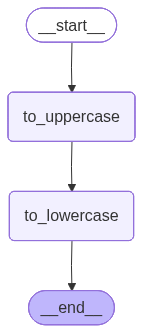

In [21]:
graph

In [22]:
# 定义一个初始化的状态
initial_state = {"text":"Hello Word"}

graph.invoke(initial_state)

[to_uppercase] Initial state: {'text': 'Hello Word'}
[to_lowercase] Received state: {'text': 'HELLO WORD'}


{'text': 'hello word'}

##  借助Pydantic对象创建图

In [23]:
from pydantic import BaseModel

class User(BaseModel):
    name: str
    age: int



In [24]:
user_data = {"name": "Alice", "age": 30}
user = User(**user_data)
print(user)

name='Alice' age=30


In [25]:
user

User(name='Alice', age=30)

In [26]:
from pydantic import BaseModel, ValidationError

# 定义一个数据模型
class User(BaseModel):
    name: str
    age: int
    email: str = None  # 可选字段

# 使用字典数据初始化
user_data = {"name": "Alice", "age": 30}
user = User(**user_data)
print(user)  # 输出：name='Alice' age=30 email=None


name='Alice' age=30 email=None


In [ ]:
# 处理数据校验
try:
    invalid_user = User(name="Bob", age="not-a-number")  # 这里age字段传入了一个错误的类型
except ValidationError as e:
    print(e) 

1 validation error for User
age
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='not-a-number', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing


In [28]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel

# 定义结构化状态
class TextState(BaseModel):
    text: str

# 定义节点处理逻辑，接受并返回 TextState
def to_uppercase(state: TextState) -> TextState:
    print(f"[to_uppercase] Initial state: {state}")
    return TextState(text=state.text.upper())

def to_lowercase(state: TextState) -> TextState:
    print(f"[to_lowercase] Received state: {state}")
    return TextState(text=state.text.lower())

# 构建图
def build_graph():
    builder = StateGraph(TextState)  # 使用 Pydantic 模型作为状态对象
    
    # 添加节点
    builder.add_node("to_uppercase", to_uppercase)
    builder.add_node("to_lowercase", to_lowercase)
    
    # 添加边
    builder.add_edge(START, "to_uppercase")  # 从起始节点到转大写节点
    builder.add_edge("to_uppercase", "to_lowercase")  # 从转大写到转小写节点
    builder.add_edge("to_lowercase", END)  # 从转小写到结束节点
    
    # 编译图
    return builder.compile()

# 执行图
def execute_graph(initial_state: TextState):
    graph = build_graph()
    final_state = graph.invoke(initial_state)
    print("\n[Final State] ->", final_state)


In [29]:
# 测试执行
initial_state = TextState(text="Hello, World!")
execute_graph(initial_state)

[to_uppercase] Initial state: text='Hello, World!'
[to_lowercase] Received state: text='HELLO, WORLD!'

[Final State] -> {'text': 'hello, world!'}


## 条件分支

In [31]:
from typing import Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

# ✅ 定义结构化状态
class UserState(BaseModel):
    age: int
    status: Optional[str] = None  # 存储用户的成年/未成年状态

# ✅ 定义各节点处理逻辑（接受 UserState，返回 UserState）
def check_age(state: UserState) -> UserState:
    print(f"[check_age] Received state: {state}")
    return state

def is_adult(state: UserState) -> bool:
    return state.age >= 18  # 判断是否成年

def handle_adult(state: UserState) -> UserState:
    print("[handle_adult] 用户是成年人")
    return UserState(age=state.age, status="Adult")

def handle_minor(state: UserState) -> UserState:
    print("[handle_minor] 用户是未成年人")
    return UserState(age=state.age, status="Minor")

# ✅ 构建图
builder = StateGraph(UserState)

builder.add_node("check_age", check_age)
builder.add_node("handle_adult", handle_adult)
builder.add_node("handle_minor", handle_minor)

# ✅ 添加条件分支
builder.add_conditional_edges("check_age", is_adult, {
    True: "handle_adult",   # 如果是成年人，执行 handle_adult
    False: "handle_minor"   # 如果是未成年人，执行 handle_minor
})

# ✅ 衔接起始和结束
builder.add_edge(START, "check_age")
builder.add_edge("handle_adult", END)
builder.add_edge("handle_minor", END)


In [32]:
# ✅ 编译图
graph = builder.compile()

# ✅ 执行测试
print("\n✅ 测试 age=20（成年人）")
graph.invoke(UserState(age=20))


✅ 测试 age=20（成年人）
[check_age] Received state: age=20 status=None
[handle_adult] 用户是成年人


{'age': 20, 'status': 'Adult'}

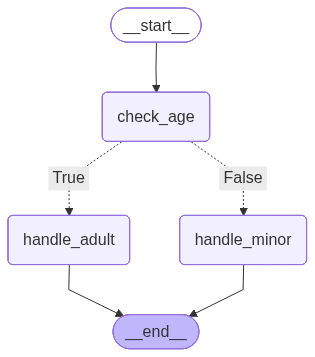

In [34]:
graph

In [33]:
print("\n✅ 测试 age=15（未成年人）")
graph.invoke(UserState(age=15))


✅ 测试 age=15（未成年人）
[check_age] Received state: age=15 status=None
[handle_minor] 用户是未成年人


{'age': 15, 'status': 'Minor'}

## 循环

In [35]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

# ✅ 1. 定义结构化状态模型
class SumState(BaseModel):
    current_sum: int
    current_number: int

# ✅ 2. 定义节点逻辑
def increment_number(state: SumState) -> SumState:
    print(f"[increment_number] 当前数字 {state.current_number}, 当前累加和 {state.current_sum}")
    return SumState(current_sum=state.current_sum + state.current_number, current_number=state.current_number + 1)

def is_done(state: SumState) -> bool:
    return state.current_number > 100

# ✅ 3. 构建图
builder = StateGraph(SumState)
builder.add_node("increment_number", increment_number)

# ✅ 4. 设置循环控制：如果 current_number > 100，结束循环，否则继续
builder.add_conditional_edges("increment_number", is_done, {
    True: END,  # 如果大于100，结束
    False: "increment_number"  # 如果小于或等于100，继续循环
})

builder.add_edge(START, "increment_number")
graph = builder.compile()


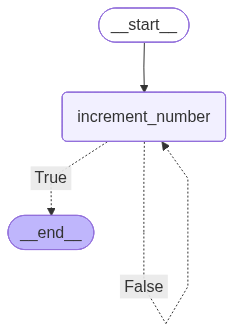

In [36]:
graph

In [40]:
# ✅ 5. 测试执行
print("\n✅ 执行累加直到 current_number > 100")
initial_state = SumState(current_sum=0, current_number=1)
final_state = graph.invoke(initial_state, config={"recursion_limit": 200})

print(f"[最终结果] -> 累加和 = {final_state['current_sum']}")


✅ 执行累加直到 current_number > 100
[increment_number] 当前数字 1, 当前累加和 0
[increment_number] 当前数字 2, 当前累加和 1
[increment_number] 当前数字 3, 当前累加和 3
[increment_number] 当前数字 4, 当前累加和 6
[increment_number] 当前数字 5, 当前累加和 10
[increment_number] 当前数字 6, 当前累加和 15
[increment_number] 当前数字 7, 当前累加和 21
[increment_number] 当前数字 8, 当前累加和 28
[increment_number] 当前数字 9, 当前累加和 36
[increment_number] 当前数字 10, 当前累加和 45
[increment_number] 当前数字 11, 当前累加和 55
[increment_number] 当前数字 12, 当前累加和 66
[increment_number] 当前数字 13, 当前累加和 78
[increment_number] 当前数字 14, 当前累加和 91
[increment_number] 当前数字 15, 当前累加和 105
[increment_number] 当前数字 16, 当前累加和 120
[increment_number] 当前数字 17, 当前累加和 136
[increment_number] 当前数字 18, 当前累加和 153
[increment_number] 当前数字 19, 当前累加和 171
[increment_number] 当前数字 20, 当前累加和 190
[increment_number] 当前数字 21, 当前累加和 210
[increment_number] 当前数字 22, 当前累加和 231
[increment_number] 当前数字 23, 当前累加和 253
[increment_number] 当前数字 24, 当前累加和 276
[increment_number] 当前数字 25, 当前累加和 300
[increment_number] 当前数字 26, 当前累加和 325
[increme

## 复杂设计

In [8]:
from pydantic import BaseModel
from typing import Optional
from langgraph.graph import StateGraph, START, END

# ✅ 1. 定义状态模型
class ProcessState(BaseModel):
    value: int
    processed: Optional[bool] = False

# ✅ 2. 定义各节点逻辑
def check_value(state: ProcessState) -> ProcessState:
    print(f"[check_value] 当前 value = {state.value}")
    return state

def is_positive(state: ProcessState) -> bool:
    return state.value > 0

def decrement(state: ProcessState) -> ProcessState:
    print(f"[decrement] value 是正数，执行 -1 → {state.value - 1}")
    return ProcessState(value=state.value - 1)

def end_process(state: ProcessState) -> ProcessState:
    print(f"[end_process] value 非正数，流程结束")
    return ProcessState(value=state.value, processed=True)

# ✅ 3. 构建图
builder = StateGraph(ProcessState)

builder.add_node("check_value", check_value)
builder.add_node("decrement", decrement)
builder.add_node("end_node", end_process)

builder.add_conditional_edges("check_value", is_positive, {
    True: "decrement",
    False: "end_node"
})

# ✅ 4. 循环逻辑：正数 → decrement → check_value
builder.add_edge("decrement", "check_value")

# ✅ 5. 起始与终点
builder.add_edge(START, "check_value")
builder.add_edge("end_node", END)

graph = builder.compile()


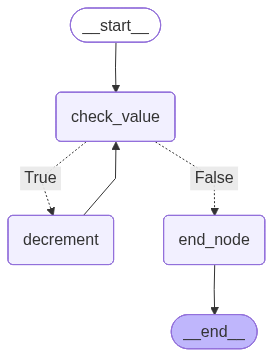

In [9]:
graph

In [10]:
# ✅ 6. 测试执行
print("\n✅ 初始 value=5（正数，进入循环）")
final_state1 = graph.invoke(ProcessState(value=5))
print("[最终结果1] ->", final_state1)


✅ 初始 value=5（正数，进入循环）
[check_value] 当前 value = 5
[decrement] value 是正数，执行 -1 → 4
[check_value] 当前 value = 4
[decrement] value 是正数，执行 -1 → 3
[check_value] 当前 value = 3
[decrement] value 是正数，执行 -1 → 2
[check_value] 当前 value = 2
[decrement] value 是正数，执行 -1 → 1
[check_value] 当前 value = 1
[decrement] value 是正数，执行 -1 → 0
[check_value] 当前 value = 0
[end_process] value 非正数，流程结束
[最终结果1] -> {'value': 0, 'processed': True}


In [11]:
print("\n✅ 初始 value=-2（非正数，直接 end）")
final_state2 = graph.invoke(ProcessState(value=-2))
print("[最终结果2] ->", final_state2)


✅ 初始 value=-2（非正数，直接 end）
[check_value] 当前 value = -2
[end_process] value 非正数，流程结束
[最终结果2] -> {'value': -2, 'processed': True}
